# Sequential feature selection algorithms

An alternative way to reduce the complexity of the model and avoid overfitting is dimensionality reduction via feature selection. 

Two main categories of dimensionality reduction techniques: 1. feature selection and 2. feature extraction. 

Feature selection: select a subset of the original features.

Feature extraction: Derive information from the feature set to construct a new feature subspace. 


Sequential feature selection algorithms:
    
To reduce an initial d-dimensional feature space to a k-dimensional feature subspace where k < d. 

Motivation: 

To automatically select a subset of features that are most relevant to the problem to improve computational 
efficiency or reduce the generalization error of the model by removing irrelevant features or noise, 
which can be useful for algorithms that donot support regularization. 


SBS sequentially removes features from the full feature subset until the new feature subspace contains the desired
number of features. 

To determine which feature is to be removed at each stage, we need to define criterion function J that we want to minimize.

The criterion calculated by the criterion function can simply be the difference in performance of the classifier after and before the removal of a particular feature. 

Then the feature to be removed at each stage can simply be defined as the feature that maximizes this criterion; or, in more intuitive terms, at each stage we eliminate the feature that causes the least performance loss after removal. 

Based on the preceding definition of SBS, we can outline the algorithm in 4 simple steps:

1.	 Initialize the algorithm with k = d , where d is the dimensionality of the full feature space Xd .

2.	 Determine the feature x' that maximizes the criterion where x ∈ Xk .

3.	 Remove the feature x'from the feature set:

4.	 Terminate if k equals the number of desired features, if not, go to step 2.

In [1]:
from IPython.display import Image
%matplotlib inline
import pandas as pd
from io import StringIO
import numpy as np

In [3]:
df_wine = pd.read_csv('pulsar_stars.csv', header=None)

df_wine.columns = [ 'Mean of the integrated profile','Standard deviation of the integrated profile','Excess kurtosis of the integrated profile','Skewness of the integrated profile','Mean of the DM-SNR curve','Standard deviation of the DM-SNR curve','Excess kurtosis of the DM-SNR curve','Skewness of the DM-SNR curve','target_class']

df_wine.head()
df_wine.dropna()

FileNotFoundError: File b'pulsar_stars.csv' does not exist

In [7]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

In [9]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

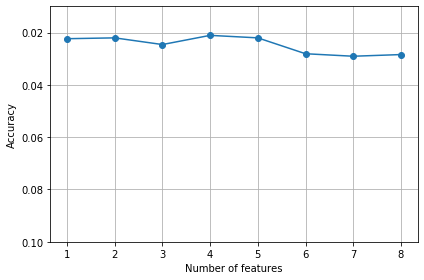

In [10]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std.astype('int'), y_train.astype('int'))

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.1, 0.01])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('./sbs.png', dpi=300)
plt.show()

In [17]:
k5 = list(sbs.subsets_[4])
print(df_wine.columns[1:][k5])

Index(['Skewness of the integrated profile', 'Mean of the DM-SNR curve',
       'Skewness of the DM-SNR curve', 'target_class'],
      dtype='object')


In [23]:
knn.fit(X_train_std.astype('int'), y_train.astype('int'))
print('Training accuracy:', knn.score(X_train_std.astype('int'), y_train.astype('int')))
print('Test accuracy:', knn.score(X_test_std.astype('int'), y_test.astype('int')))

Training accuracy: 0.07439335887611749
Test accuracy: 0.024581005586592177


In [24]:
knn.fit(X_train_std.astype('int'), y_train.astype('int'))
print('Training accuracy:', knn.score(X_train_std.astype('int'), y_train.astype('int')))
print('Test accuracy:', knn.score(X_test_std.astype('int'), y_test.astype('int')))

Training accuracy: 0.07439335887611749
Test accuracy: 0.024581005586592177


<br>
<br>

# Assessing Feature Importances with Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:2]

forest = RandomForestClassifier(n_estimators=10000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train.astype('int'), y_train.astype('int'))
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

# plt.title('Feature Importances')
# plt.bar(range(X_train.shape[1]), 
#         importances[indices],
#         color='lightblue', 
#         align='center')

# plt.xticks(range(X_train.shape[1]), 
#            feat_labels[indices], rotation=90)
# plt.xlim([-1, X_train.shape[1]])
# plt.tight_layout()
# #plt.savefig('./random_forest.png', dpi=300)
# plt.show()

In [36]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold=0.01, prefit=True)
X_selected = sfm.transform(X_train.astype('int'))

X_selected.shape

ZeroDivisionError: division by zero

Now, let's print the 3 features that met the threshold criterion for feature selection that we set earlier (note that this code snippet does not appear in the actual book but was added to this notebook later for illustrative purposes):

In [31]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

NameError: name 'X_selected' is not defined

<br>
<br>

# Summary

...